<a href="https://colab.research.google.com/github/akemisetti/ucsfimaging/blob/master/otsu_segmentation_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install scikit-image --upgrade
!pip install nibabel
!pip install nilearn

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.16.2)


In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
import skimage
from skimage.filters import threshold_multiotsu
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
%matplotlib inline

In [0]:
skimage.__version__

'0.16.2'

In [0]:
from urllib.request import urlretrieve
urlretrieve("https://github.com/akemisetti/ucsfimaging/blob/master/T_template0_BrainCerebellum.nii.gz?raw=true","T_template0_BrainCerebellum.nii.gz")

('T_template0_BrainCerebellum.nii.gz',
 <http.client.HTTPMessage at 0x7f5b357dec18>)

## Reading the images using nibabel

In [0]:
import nibabel as nib
img = nib.load('T_template0_BrainCerebellum.nii.gz')

In [0]:
img.shape

(176, 196, 216)

In [0]:
#Please click on the image below to explore. By default it will be blanks showing guides
from nilearn import plotting
plotting.view_img(img)

## Using SK Image MultiOtsu Implementation

In [0]:
def visualize(x,y,z):
    
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))
    imagex = img.get_data()[x,:,:]
    thresholdsx = threshold_multiotsu(imagex)
    regionsx = np.digitize(imagex, bins=thresholdsx)
    
    imagey = img.get_data()[:,y,:]
    thresholdsy = threshold_multiotsu(imagey)
    regionsy = np.digitize(imagey, bins=thresholdsy)
    
    imagez = img.get_data()[:,:,z]
    thresholdsz = threshold_multiotsu(imagez)
    regionsz = np.digitize(imagez, bins=thresholdsz)

    ax[0,0].imshow(imagex, cmap='gray')
    ax[0,0].set_title('Original along x')
    ax[0,0].axis('off')

    ax[0,1].hist(imagex.ravel(), bins=255)
    ax[0,1].set_title('Histogram along x')
    for thresh in thresholdsx:
        ax[0,1].axvline(thresh, color='r')

    ax[0,2].imshow(regionsx, cmap='Accent')
    ax[0,2].set_title('Multi-Otsu result along x')
    ax[0,2].axis('off')

    ax[1,0].imshow(imagey, cmap='gray')
    ax[1,0].set_title('Original along y')
    ax[1,0].axis('off')

    ax[1,1].hist(imagey.ravel(), bins=255)
    ax[1,1].set_title('Histogram along y ')
    for thresh in thresholdsy:
        ax[1,1].axvline(thresh, color='r')

    ax[1,2].imshow(regionsy, cmap='Accent')
    ax[1,2].set_title('Multi-Otsu result along y')
    ax[1,2].axis('off')

    ax[2,0].imshow(imagez, cmap='gray')
    ax[2,0].set_title('Original along y')
    ax[2,0].axis('off')

    ax[2,1].hist(imagez.ravel(), bins=255)
    ax[2,1].set_title('Histogram along y ')
    for thresh in thresholdsz:
        ax[2,1].axvline(thresh, color='r')

    ax[2,2].imshow(regionsz, cmap='Accent')
    ax[2,2].set_title('Multi-Otsu result along y')
    ax[2,2].axis('off')
    
    plt.subplots_adjust()

    plt.show()

In [0]:
interact(visualize,x=IntSlider(value=50,min=0, max=img.shape[0] -1, step=1),
        y=IntSlider(value=50,min=10, max=img.shape[1] -1, step=1),
        z=IntSlider(value=50,min=10, max=img.shape[2] -1, step=1));

interactive(children=(IntSlider(value=50, description='x', max=175), IntSlider(value=50, description='y', max=…

## Implementing normalized histogram (probabilities)

In [0]:
import cv2         
import numpy as np  
_test_slice = img.get_data()[:,:,50]

In [0]:
np.amax(_test_slice), np.amin(_test_slice)

(9.175321, 0.0)

#### My Implementation of proababilities
Intensities are captured as floting point values. The max value of the sample image is 9.175321 and min value is 0.0. There are infinite value which would be possible for a floating point datatype. Instead we will try to limit to 256 bins and use the center value of the bin as the value. 

In [0]:
def probabilities(img, bins):
    img = img.flatten()
    hist, bine = np.histogram(img, bins=bins)
    binc = (bine[:-1] + bine[1:])/2.0
    hist = hist / np.sum(hist)
    return hist, binc

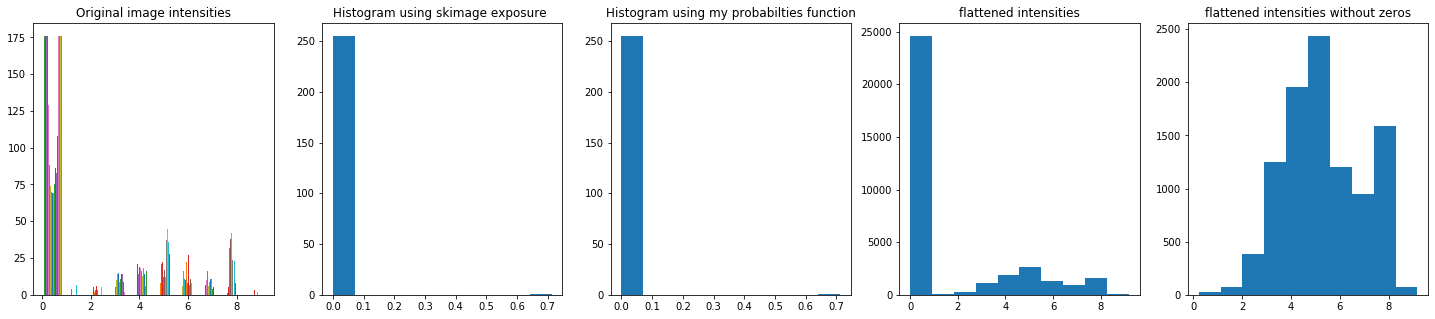

In [0]:
from skimage import data, exposure, img_as_float
_fs = _test_slice.flatten();
fs_nz = [x for x in _fs if x > 0.0]
hist, bin_centers = exposure.histogram(_fs,normalize=True)
h, bc = probabilities(_test_slice, 256)

fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(25, 5))
ax[0].hist( _test_slice)
ax[0].set_title('Original image intensities')

ax[1].hist(hist)
ax[1].set_title('Histogram using skimage exposure ')

ax[2].hist(h)
ax[2].set_title('Histogram using my probabilties function')

ax[3].hist(_fs)
ax[3].set_title('flattened intensities')

ax[4].hist(fs_nz)
ax[4].set_title('flattened intensities without zeros')

plt.subplots_adjust()
plt.show()

In [0]:
len(bin_centers), hist.shape, len(bc), h.shape

(256, (256,), 256, (256,))

## My implementation of the multiple otsu
I am using the paper 
https://ftp.iis.sinica.edu.tw/JISE/2001/200109_01.pdf
for this implementation



In [0]:
def get_thresholds(probs, centers):
    # Initialize the array structures
    _thresholds = 3
    maxSig = 0.0
    bins = 256
    end = bins-1
    idx = np.zeros(_thresholds-1, dtype='int')
    thresholds = np.zeros(_thresholds-1)
    P = np.zeros((bins,bins))
    S = np.zeros((bins,bins))
    H = np.zeros((bins,bins))
    
    # Populate the diagnol
    for i in range(1,end):
        P[i,i] = probs[i];
        S[i,i] = i*probs[i];
        
    # populating the first row
    for i in range(1,end):
        P[1,i+1] = P[1,i] + h[i+1];
        S[1,i+1] = S[1,i] + (i+1)*h[i+1];
        
    # Populating others rows using first row
    for i in range(2,end):
        for j in range(i+1, end):
            P[i,j] = P[1,j] - P[1,i-1]
            S[i,j] = S[1,j] - S[1,i-1]
                
    #now calculate H
    for i in range(1,end):
        for j in range(i+1, end):
            if P[i,j] != 0:
                H[i,j] = (S[i,j]*S[i,j])/P[i,j];
            else:
                H[i,j] = 0.0;
      
    # find max Sigma
    levels = bins-_thresholds
    for i in range(1, levels): # This is the t1 Loop
        for j in range(i,levels+1): # This is the t2 Loop 
            sig = H[1,i] + H[i+1,j] + H[j+1,end]
            if maxSig < sig:
                idx[0] = i
                idx[1] = j
                maxSig = sig
    
    thresholds[0] = centers[idx[0]]
    thresholds[1] = centers[idx[1]]
    
    return thresholds 

In [0]:
get_thresholds(h,bc)

array([5.71665478, 9.04987717])

In [0]:
threshold_multiotsu(_test_slice)

array([4.24717  , 6.2542715], dtype=float32)

In [0]:
def visualize_my(x,y,z):
    
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))
    imagex = img.get_data()[x,:,:]
    h, bc = probabilities(imagex, 256)
    thresholdsx = get_thresholds(h,bc)
    regionsx = np.digitize(imagex, bins=thresholdsx)
    
    imagey = img.get_data()[:,y,:]
    h, bc = probabilities(imagey, 256)
    thresholdsy = get_thresholds(h,bc)
    regionsy = np.digitize(imagey, bins=thresholdsy)
    
    imagez = img.get_data()[:,:,z]
    h, bc = probabilities(imagez, 256)
    thresholdsz = get_thresholds(h,bc)
    regionsz = np.digitize(imagez, bins=thresholdsz)

    ax[0,0].imshow(imagex, cmap='gray')
    ax[0,0].set_title('Original along x')
    ax[0,0].axis('off')

    ax[0,1].hist(imagex.ravel(), bins=255)
    ax[0,1].set_title('Histogram along x')
    for thresh in thresholdsx:
        ax[0,1].axvline(thresh, color='r')

    ax[0,2].imshow(regionsx, cmap='Accent')
    ax[0,2].set_title('Multi-Otsu result along x')
    ax[0,2].axis('off')

    ax[1,0].imshow(imagey, cmap='gray')
    ax[1,0].set_title('Original along y')
    ax[1,0].axis('off')

    ax[1,1].hist(imagey.ravel(), bins=255)
    ax[1,1].set_title('Histogram along y ')
    for thresh in thresholdsy:
        ax[1,1].axvline(thresh, color='r')

    ax[1,2].imshow(regionsy, cmap='Accent')
    ax[1,2].set_title('Multi-Otsu result along y')
    ax[1,2].axis('off')

    ax[2,0].imshow(imagez, cmap='gray')
    ax[2,0].set_title('Original along y')
    ax[2,0].axis('off')

    ax[2,1].hist(imagez.ravel(), bins=255)
    ax[2,1].set_title('Histogram along y ')
    for thresh in thresholdsz:
        ax[2,1].axvline(thresh, color='r')

    ax[2,2].imshow(regionsz, cmap='Accent')
    ax[2,2].set_title('Multi-Otsu result along y')
    ax[2,2].axis('off')
    
    plt.subplots_adjust()

    plt.show()

In [0]:
interact(visualize_my,x=IntSlider(value=50,min=0, max=img.shape[0] -1, step=1),
        y=IntSlider(value=50,min=10, max=img.shape[1] -1, step=1),
        z=IntSlider(value=50,min=10, max=img.shape[2] -1, step=1));

interactive(children=(IntSlider(value=50, description='x', max=175), IntSlider(value=50, description='y', max=…

In [0]:
# Failed to handle nii images using opencv needs more investigation. It was giving segmentation core dump
# img_ts = _test_slice.astype(np.uint8)
# #vis2 = cv2.CreateMat(img_cv, cv2.CV_8UC1)
# ret2,th2 = cv2.threshold(img_ts,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# cv2.imshow("Image with background removed", ret2)

## My implementation of the otus algorithms for single threshold
I have followed the following paper for it.
https://ieeexplore.ieee.org/document/6553987

In [0]:
def get_one_level_vals(probs, level):
    
    bins = 256
    omega0 = 0
    omega1 = 0
    
    mu0 = 0
    mu1 = 0
    
    muT = 0
    sig_sq = 0
    
    for i in range(0, level):
        omega0 = omega0+probs[i]
        if omega0 != 0:
            mu0 = mu0 + (i*probs[i]/omega0)
        
    for i in range(level, bins):
        omega1 = omega1+probs[i]
        if omega1 != 0:
            mu1 = mu1 + (i*probs[i]/omega1)   
        
    for i in range(0, bins):
        muT = muT + i*probs[i]
    
    sig_sq = omega0*(mu0 - muT)*(mu0 - muT) +  omega1*(mu1 - muT)*(mu1 - muT)
    
    return sig_sq

In [0]:
def get_threshold_paper(im):
    bins = 256
    probs, bc = probabilities(im, 256)
    sig_sqs = np.zeros(bins)
    for i in range(0,256):
        sig_sqs[i] = get_one_level_vals(probs,i)
    arg_sort = np.argsort(sig_sqs)[::-1][:256]
    
    return bc[arg_sort[0]]

In [0]:
get_threshold_paper(_test_slice)

1.7741342

In [0]:
def visualize_paper(x,y,z):
    
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 18))
    imagex = img.get_data()[x,:,:]
    thresholdsx = get_threshold_paper(imagex)
    regionsx = np.digitize(imagex, bins=[thresholdsx])
    
    imagey = img.get_data()[:,y,:]
    thresholdsy = get_threshold_paper(imagey)
    regionsy = np.digitize(imagey, bins=[thresholdsy])
    
    imagez = img.get_data()[:,:,z]
    thresholdsz = get_threshold_paper(imagez)
    regionsz = np.digitize(imagez, bins=[thresholdsz])

    ax[0,0].imshow(imagex, cmap='gray')
    ax[0,0].set_title('Original along x')
    ax[0,0].axis('off')

    ax[0,1].hist(imagex.ravel(), bins=255)
    ax[0,1].set_title('Histogram along x')
    ax[0,1].axvline(thresholdsx, color='r')

    ax[0,2].imshow(regionsx, cmap='Accent')
    ax[0,2].set_title('Multi-Otsu result along x')
    ax[0,2].axis('off')

    ax[1,0].imshow(imagey, cmap='gray')
    ax[1,0].set_title('Original along y')
    ax[1,0].axis('off')

    ax[1,1].hist(imagey.ravel(), bins=255)
    ax[1,1].set_title('Histogram along y ')
    ax[1,1].axvline(thresholdsy, color='r')

    ax[1,2].imshow(regionsy, cmap='Accent')
    ax[1,2].set_title('Multi-Otsu result along y')
    ax[1,2].axis('off')

    ax[2,0].imshow(imagez, cmap='gray')
    ax[2,0].set_title('Original along y')
    ax[2,0].axis('off')

    ax[2,1].hist(imagez.ravel(), bins=255)
    ax[2,1].set_title('Histogram along y ')
    ax[2,1].axvline(thresholdsz, color='r')

    ax[2,2].imshow(regionsz, cmap='Accent')
    ax[2,2].set_title('Multi-Otsu result along y')
    ax[2,2].axis('off')
    
    plt.subplots_adjust()

    plt.show()

In [0]:
interact(visualize_paper,x=IntSlider(value=50,min=0, max=img.shape[0] -1, step=1),
        y=IntSlider(value=50,min=10, max=img.shape[1] -1, step=1),
        z=IntSlider(value=50,min=10, max=img.shape[2] -1, step=1));

interactive(children=(IntSlider(value=50, description='x', max=175), IntSlider(value=50, description='y', max=…